In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
basetable_train = pd.read_csv('../../Data/Gold/basetable_train.csv')
basetable_test = pd.read_csv('../../Data/Gold/basetable_test.csv')

In [26]:
basetable_train.columns

Index(['niveau', 'ervaring_schepper', 'ervaring_kopper', 'ervaring_duo',
       'is_thuisploeg', 'kwart', 'is_schepper_bank', 'is_kopper_bank',
       'schepper_pos_rechts', 'kop_verplaatsen_achter', 'kop_veel_verplaatsen',
       'kop_hor_verplaatsen', 'goal', 'score_verschil_voor', 'score_eigen',
       'score_tegenstander', 'wedstrijd_corner_nr',
       'ploeg_wedstrijd_corner_nr', 'periode', 'positie_verticaal_voor',
       'positie_horizontaal', 'ploeg_scoreperc', 'goal_lag_ploeg',
       'goal_lag_wedstrijd', 'klassement', 'klassement_veschil',
       'is_degradatieplaats', 'is_promotieplaats'],
      dtype='object')

### Scaling and Onehotencoding

In [27]:
# Onehot encoding
cat_cols = ["niveau", "kwart", "positie_horizontaal", "periode"]

# Combine train and test to ensure consistent columns
combined = pd.concat([basetable_train, basetable_test], keys=["train", "test"])

# One-hot encode only the categorical columns
combined_encoded = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into train and test
train_df_encoded = combined_encoded.xs("train")
test_df_encoded = combined_encoded.xs("test")



In [28]:
#TODO Standard scaler

In [29]:
# MinMaxscaling numerical columns
from sklearn.preprocessing import StandardScaler

# 1. Select numerical columns (exclude dummies)
numerical_cols = ["ervaring_schepper", "ervaring_kopper", "ervaring_duo",
                   "score_verschil_voor", "score_eigen", "score_tegenstander", "wedstrijd_corner_nr", 
                   "ploeg_wedstrijd_corner_nr", 'klassement', 'klassement_veschil', 'ploeg_scoreperc']

# 2. Fit scaler on train only
scaler = StandardScaler()
scaler.fit(train_df_encoded[numerical_cols])

# 3. Transform train and test
train_df_encoded[numerical_cols] = scaler.transform(train_df_encoded[numerical_cols])
test_df_encoded[numerical_cols] = scaler.transform(test_df_encoded[numerical_cols])


C:\Users\cosyn\AppData\Local\Temp\ipykernel_30944\301380221.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_encoded[numerical_cols] = scaler.transform(train_df_encoded[numerical_cols])
C:\Users\cosyn\AppData\Local\Temp\ipykernel_30944\301380221.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_encoded[numerical_cols] = scaler.transform(test_df_encoded[numerical_cols])


### features and target

In [30]:
X_train = train_df_encoded.drop("goal", axis=1)
y_train = train_df_encoded["goal"]

X_test = test_df_encoded.drop("goal", axis=1)
y_test = test_df_encoded["goal"]

### Baseline logistic model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [32]:

# 2. Instantiate baseline logistic regression (no tuning)
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# 3. Fit model
baseline_model.fit(X_train, y_train)

# 4. Predict
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:,1]

In [33]:
def plot_roc_curve(y_true, y_proba, label="Model", color="blue"):
    """
    Plots ROC curve for a given set of true labels and predicted probabilities.
    
    Parameters:
    - y_true: Ground truth binary labels (1D array-like)
    - y_proba: Predicted probabilities for the positive class (1D array-like)
    - label: Label for the legend (e.g., model name)
    - color: Line color in the plot
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})", color=color)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

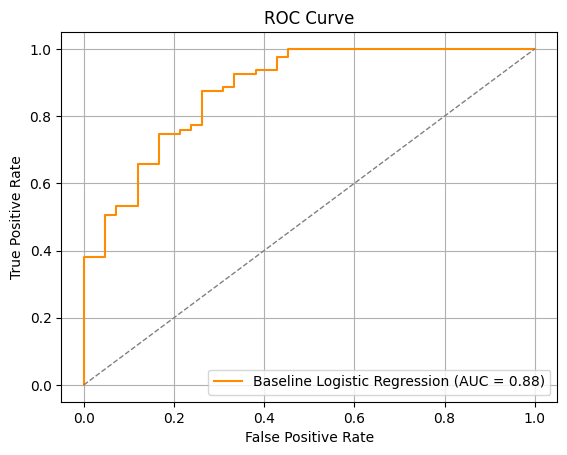

In [34]:
plot_roc_curve(y_test, y_proba_baseline, label="Baseline Logistic Regression", color="darkorange")


In [35]:
def plot_confusion_matrix(y_true, y_pred, labels=[0, 1], normalize=None, title="Confusion Matrix", cmap="Blues"):
    """
    Plots a confusion matrix.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - labels: List of class labels (default [0, 1])
    - normalize: {‘true’, ‘pred’, ‘all’}, default=None. Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population.
    - title: Plot title
    - cmap: Color map
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, values_format=".2f" if normalize else "d")
    plt.title(title)
    plt.grid(False)
    plt.show()

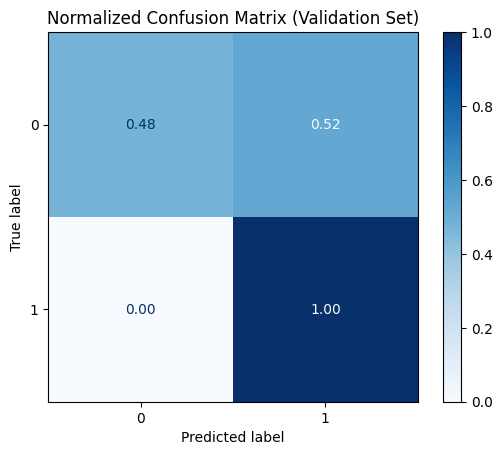

In [36]:
plot_confusion_matrix(y_test, y_pred_baseline, normalize="true", title="Normalized Confusion Matrix (Validation Set)", cmap="Blues")

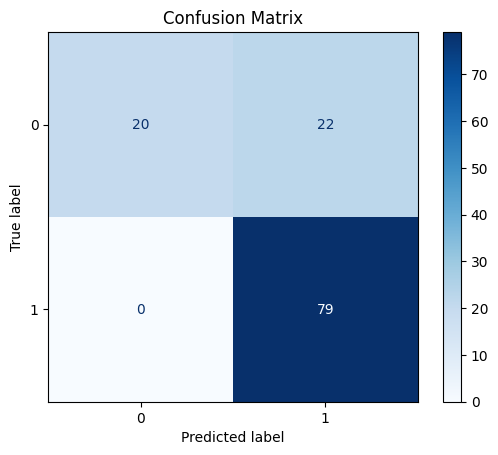

In [37]:
plot_confusion_matrix(y_test, y_pred_baseline)


In [38]:
def print_classification_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    """
    Prints classification metrics for binary classification.
    
    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels
    - y_proba: Predicted probabilities (optional, for ROC AUC)
    - model_name: Name of the model (for display)
    """
    print(f"\n📊 Classification Report for {model_name}:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC AUC:   {roc_auc_score(y_true, y_proba):.4f}")


In [39]:
print_classification_metrics(y_test, y_pred_baseline, y_proba_baseline, model_name="Baseline Logistic Regression")


📊 Classification Report for Baseline Logistic Regression:
Accuracy:  0.8182
Precision: 0.7822
Recall:    1.0000
F1 Score:  0.8778
ROC AUC:   0.8810


In [40]:
import shap
shap.initjs()

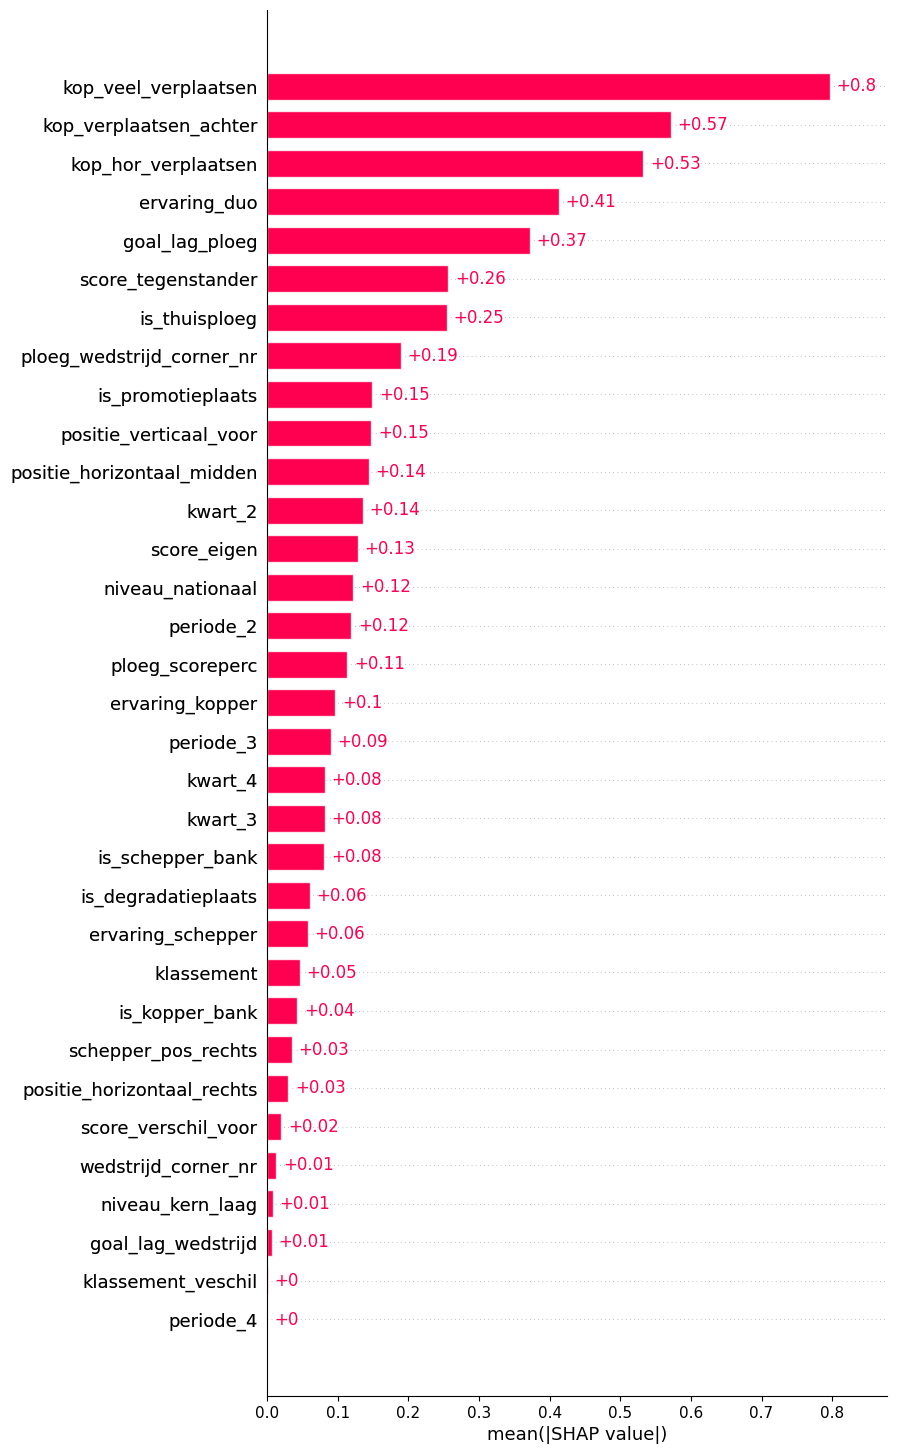

In [41]:
explainer_base = shap.Explainer(baseline_model, X_train)
shap_values = explainer_base(X_test)
shap.plots.bar(shap_values.abs.mean(0), max_display= len(X_test.columns))

In [42]:
base_array = X_test.to_numpy()

In [43]:
shap_values.shape

(121, 33)

### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
def train_random_forest_with_tuning(X_train, X_test, y_train):
    """
    Trains a Random Forest with hyperparameter tuning using RandomizedSearchCV.
    
    Parameters:
    - X_train: training features (DataFrame)
    - X_test: test features (DataFrame)
    - y_train: training labels (Series)

    Returns:
    - best_model: trained RandomForestClassifier with best parameters
    - y_pred: predicted class labels for X_test
    - y_proba: predicted class 1 probabilities for X_test
    """
    rf = RandomForestClassifier(random_state=42)

    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "class_weight": [None, "balanced"]
    }

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    return best_model, y_pred, y_proba, best_params

In [46]:
best_rf_model, y_pred_rf, y_proba_rf, best_param_rf = train_random_forest_with_tuning(X_train, X_test, y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


NameError: name 'best_param' is not defined

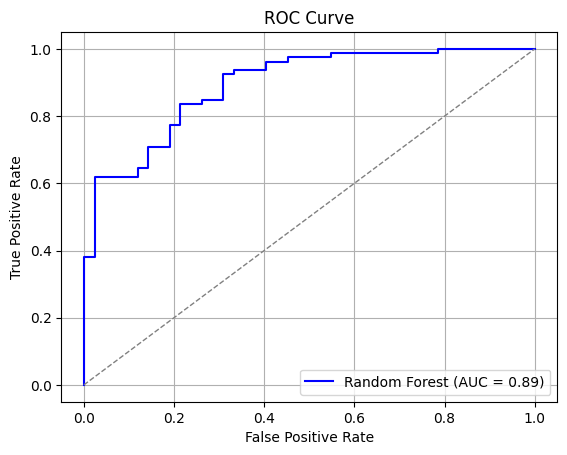

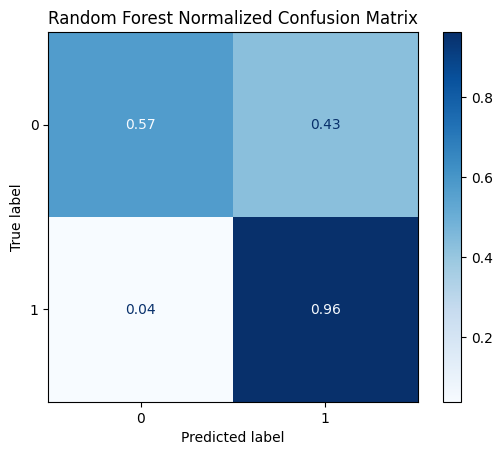

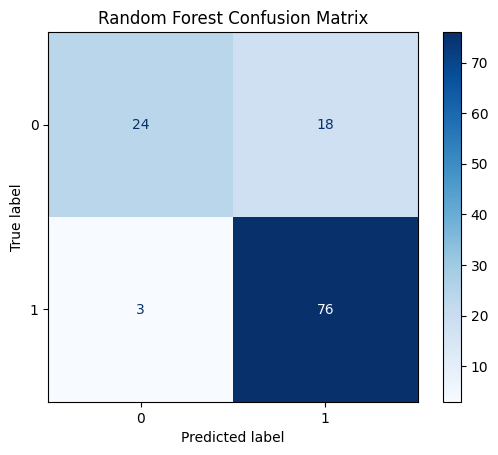


📊 Classification Report for Random Forest:
Accuracy:  0.8264
Precision: 0.8085
Recall:    0.9620
F1 Score:  0.8786
ROC AUC:   0.8927


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf, label="Random Forest")
plot_confusion_matrix(y_test, y_pred_rf, normalize="true", title="Random Forest Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, title = "Random Forest Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf, y_proba_rf, model_name="Random Forest")


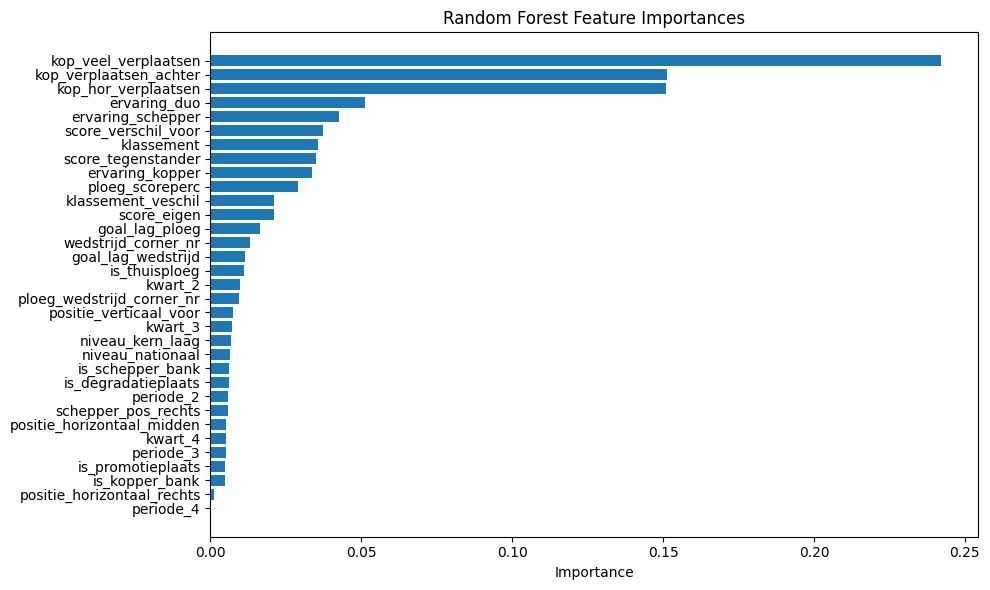

In [ ]:
### Feature importances
# Extract importances
importances = best_rf_model.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

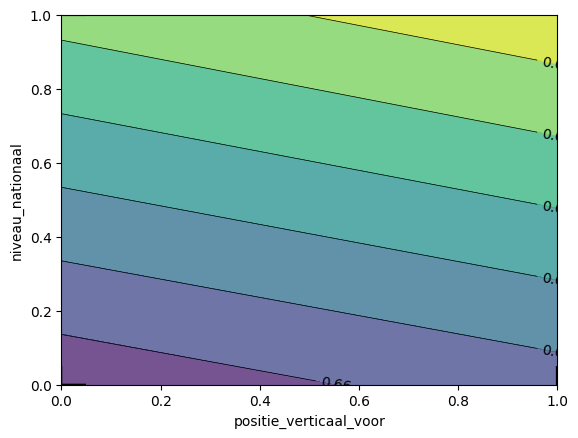

In [ ]:
### kijken naar partial dependence plot niveau en 
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = [('positie_verticaal_voor', 'niveau_nationaal')]  # dummy names!

PartialDependenceDisplay.from_estimator(
    best_rf_model,
    X_train,
    features=features_to_plot,
    kind='average',  # can also do 'individual'
    grid_resolution=20
)

In [ ]:
# 1. Compute SHAP interaction values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer(X_test, interactions=True)

# 2. Get feature names and indices
feature_names = X_test.columns.tolist()
feat_1 = feature_names.index("positie_verticaal_voor")
feat_2 = feature_names.index("niveau_nationaal")

# 3. Extract correct values
x_vals = X_test.iloc[:, feat_1]
interaction_vals = shap_values.values[:, feat_1, feat_2, 1]
color_vals = X_test.iloc[:, feat_2]

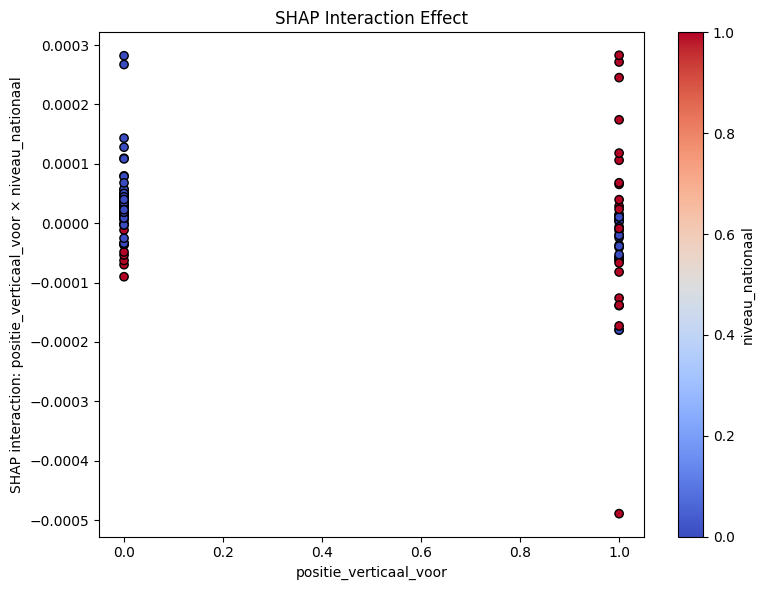

In [ ]:

# 4. Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_vals,
    interaction_vals,
    c=color_vals,
    cmap="coolwarm",
    edgecolor="k"
)
plt.xlabel("positie_verticaal_voor")
plt.ylabel(f"SHAP interaction: {feature_names[feat_1]} × {feature_names[feat_2]}")
plt.title("SHAP Interaction Effect")
plt.colorbar(sc, label=feature_names[feat_2])
plt.tight_layout()
plt.show()


In [ ]:
### permutations for selecting right features
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

In [ ]:
def cross_validated_permutation_importance(
    model_class, X, y, param_dict=None, scoring="roc_auc", n_splits=5, n_repeats=10, random_state=42, top_n=None
):
    """
    Compute and plot cross-validated permutation importances.

    Parameters:
    - model_class: sklearn model class (e.g., RandomForestClassifier)
    - X, y: pandas DataFrame and Series (features and target)
    - param_dict: dict of model hyperparameters
    - scoring: string, scoring metric for permutation importance (e.g., 'roc_auc')
    - n_splits: number of cross-validation folds
    - n_repeats: number of permutations per feature
    - random_state: random seed
    - top_n: number of top features to plot (optional)

    Returns:
    - DataFrame of average importances per feature
    """
    if param_dict is None:
        param_dict = {}

    importances_list = []
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        model = model_class(**param_dict, random_state=random_state)
        model.fit(X_train_cv, y_train_cv)

        result = permutation_importance(
            model, X_val_cv, y_val_cv,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )

        importances_list.append(result.importances_mean)

    mean_importances = np.mean(importances_list, axis=0)

    importance_df = pd.DataFrame({
        "feature": X.columns,
        "mean_importance": mean_importances
    }).sort_values(by="mean_importance", ascending=False)

    # Plot
    plot_df = importance_df.head(top_n) if top_n else importance_df
    plt.figure(figsize=(10, 6))
    plt.barh(plot_df["feature"], plot_df["mean_importance"])
    plt.gca().invert_yaxis()
    plt.title("Cross-Validated Permutation Feature Importances")
    plt.xlabel("Mean Decrease in ROC AUC")
    plt.tight_layout()
    plt.show()

    return importance_df

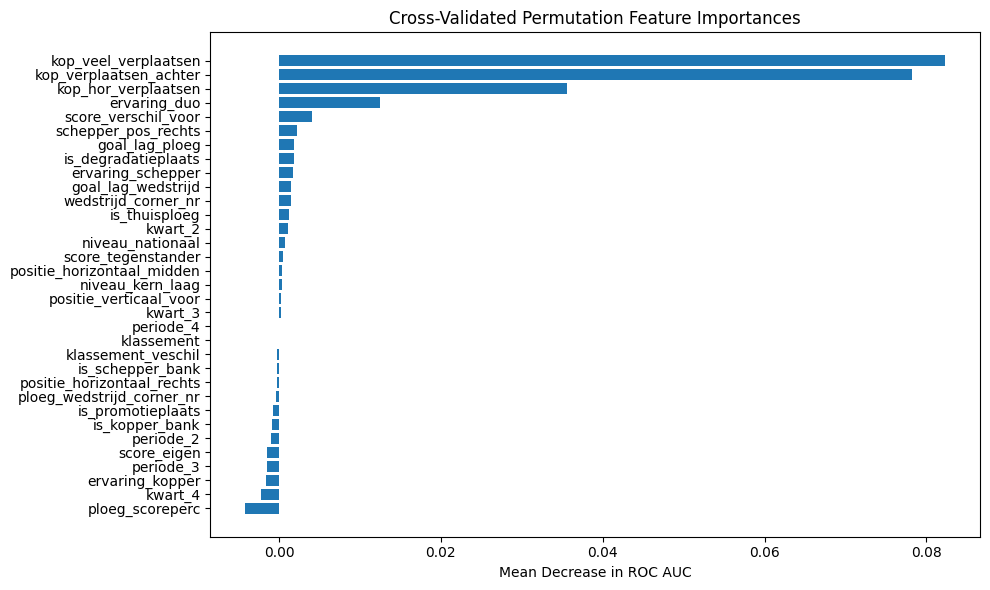

In [ ]:
rf_permuted = cross_validated_permutation_importance(
    model_class=RandomForestClassifier,
    X=X_train,
    y=y_train,
    param_dict=best_param_rf,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
    
)


In [ ]:
rf_permuted.head()

,feature,mean_importance
8,kop_veel_verplaatsen,0.082311
7,kop_verplaatsen_achter,0.078261
9,kop_hor_verplaatsen,0.035579
2,ervaring_duo,0.012470
10,score_verschil_voor,0.004043


In [ ]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_rf = rf_permuted[rf_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use = [item for item in rf_permuted["feature"].to_list() if item not in feat_to_remove_rf]

In [ ]:
### rf without negative contribution of features
best_rf_model_pos_con, y_pred_rf_pos_con, y_proba_rf_pos_con, best_param_rf_pos_con = train_random_forest_with_tuning(X_train[cols_to_use], X_test[cols_to_use], y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


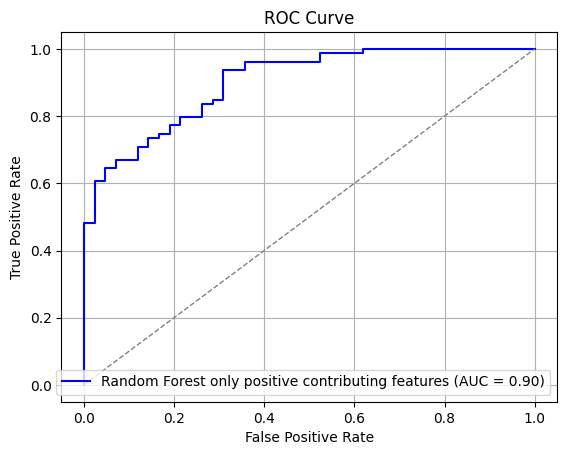

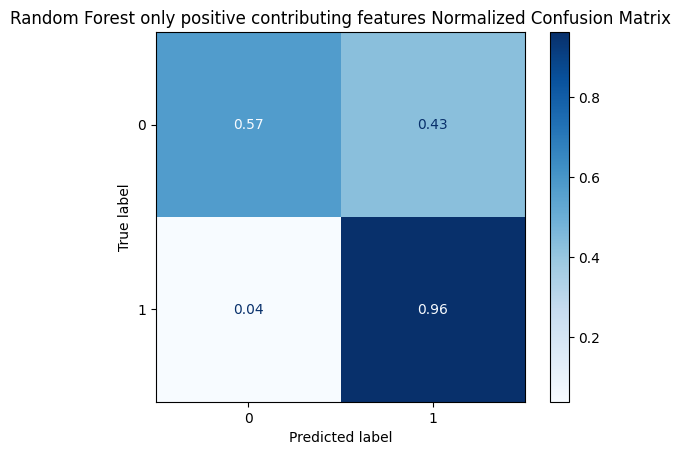

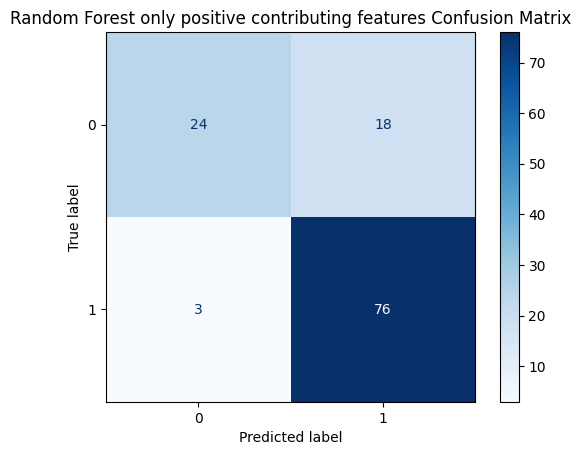


📊 Classification Report for Random Forest only positive contributing features:
Accuracy:  0.8264
Precision: 0.8085
Recall:    0.9620
F1 Score:  0.8786
ROC AUC:   0.9017


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_pos_con, label="Random Forest only positive contributing features")
plot_confusion_matrix(y_test, y_pred_rf_pos_con, normalize="true", title="Random Forest only positive contributing features Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_pos_con, title = "Random Forest only positive contributing features Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_pos_con, y_proba_rf_pos_con, model_name="Random Forest only positive contributing features")


### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:


def train_xgb_with_tuning(X_train, X_test, y_train):
    """
    Trains an XGBoost model with hyperparameter tuning using RandomizedSearchCV.
    
    Parameters:
    - X_train: training features (DataFrame)
    - X_test: test features (DataFrame)
    - y_train: training labels (Series)

    Returns:
    - best_model: trained XGBClassifier with best parameters
    - y_pred: predicted class labels for X_test
    - y_proba: predicted class 1 probabilities for X_test
    - best_params: best hyperparameters
    """
    xgb = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )

    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.8, 1],
        "scale_pos_weight": [0.5, 1]  
        }

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    return best_model, y_pred, y_proba, best_params


In [ ]:
best_xgb_model, y_pred_xgb, y_proba_xgb, best_param_xgb = train_xgb_with_tuning(X_train, X_test, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


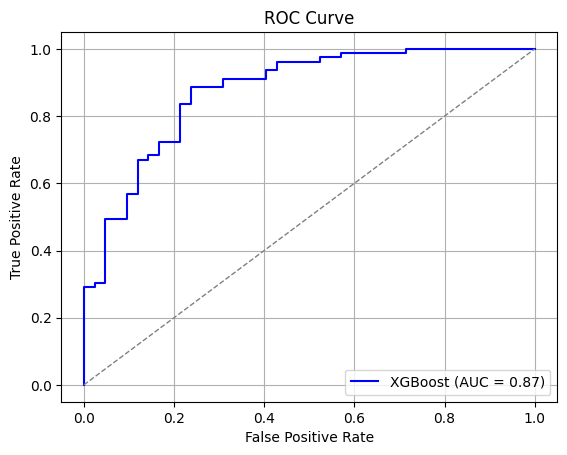

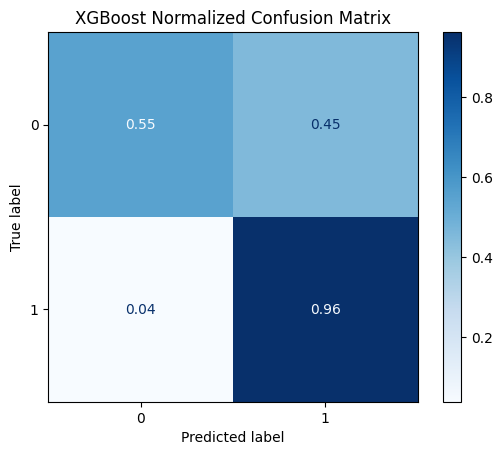

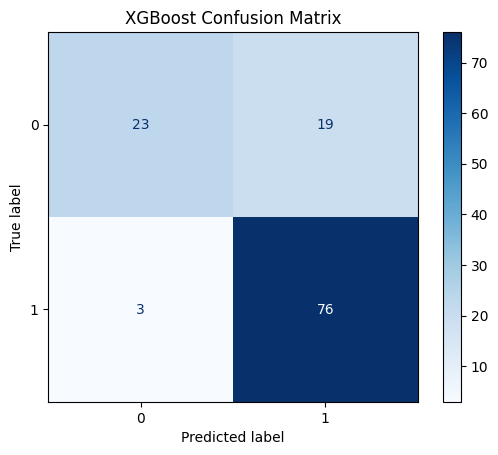


📊 Classification Report for XGBoost:
Accuracy:  0.8182
Precision: 0.8000
Recall:    0.9620
F1 Score:  0.8736
ROC AUC:   0.8749


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb, label="XGBoost")
plot_confusion_matrix(y_test, y_pred_xgb, normalize="true", title="XGBoost Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, title = "XGBoost Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb, y_proba_xgb, model_name="XGBoost")


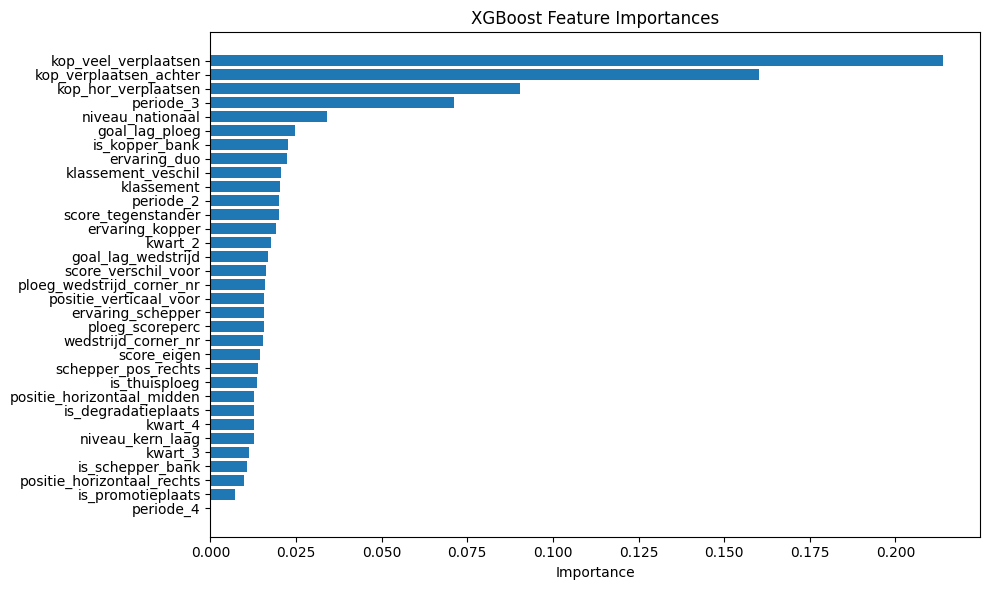

In [ ]:
### Feature importances xgboost
# Extract importances
importances = best_xgb_model.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

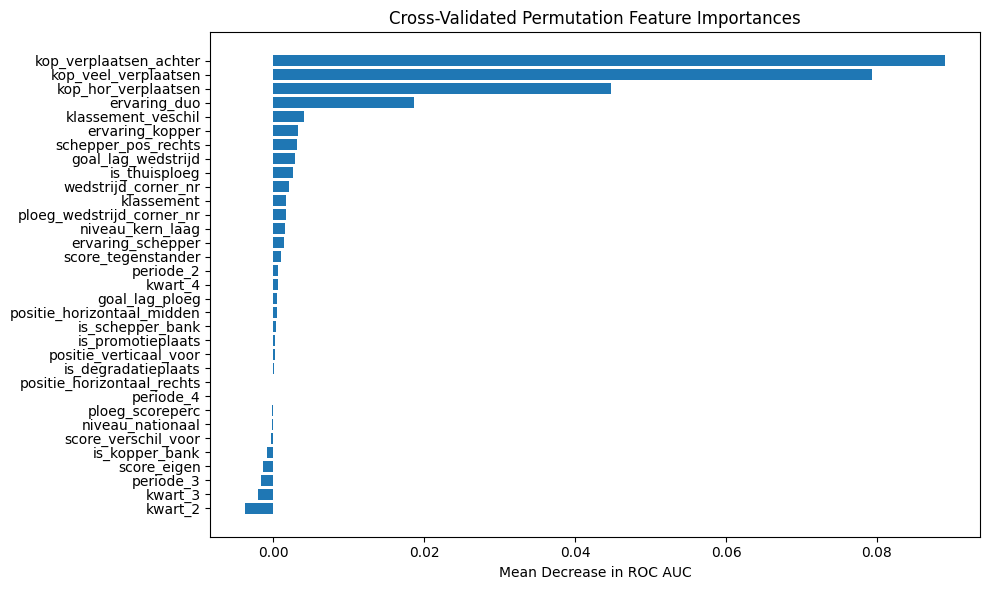

In [ ]:
### permuting
xgb_permuted = cross_validated_permutation_importance(
    model_class=XGBClassifier,
    X=X_train,
    y=y_train,
    param_dict=best_param_xgb,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
)

In [ ]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_xgb = xgb_permuted[xgb_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use_xgb = [item for item in xgb_permuted["feature"].to_list() if item not in feat_to_remove_xgb]

In [ ]:
### xgb without negative contribution of features
best_xgb_model_pos_con, y_pred_xgb_pos_con, y_proba_xgb_pos_con, best_param_xgb_pos_con = train_random_forest_with_tuning(X_train[cols_to_use_xgb], X_test[cols_to_use_xgb], y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


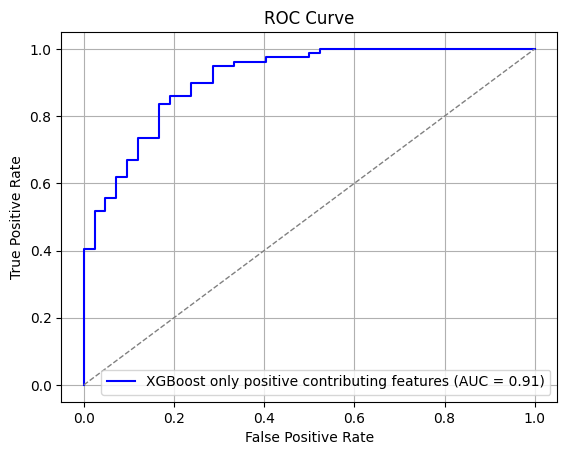

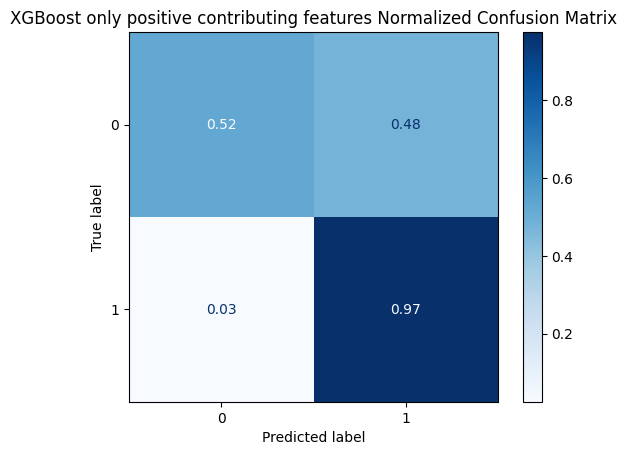

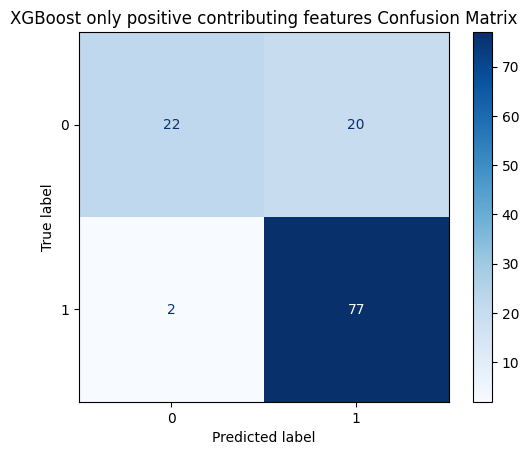


📊 Classification Report for XGBoost only positive contributing features:
Accuracy:  0.8182
Precision: 0.7938
Recall:    0.9747
F1 Score:  0.8750
ROC AUC:   0.9111


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_pos_con, label="XGBoost only positive contributing features")
plot_confusion_matrix(y_test, y_pred_xgb_pos_con, normalize="true", title="XGBoost only positive contributing features Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_pos_con, title = "XGBoost only positive contributing features Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_pos_con, y_proba_xgb_pos_con, model_name="XGBoost only positive contributing features")


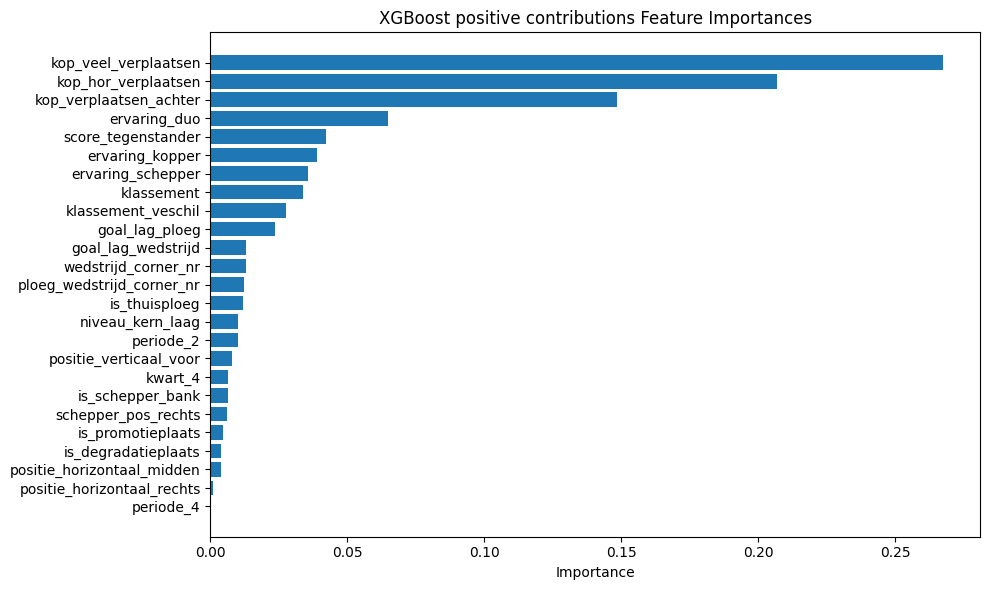

In [ ]:
### feat importances improved model
# Ensure your feature importances and names match in length
# Extract importances
importances = best_xgb_model_pos_con.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train[cols_to_use_xgb].columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost positive contributions Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Comparison

In [ ]:
def plot_multiple_roc_curves_from_scores(score_dict: dict, y_true, title="ROC Curves"):
    """
    Plot ROC curves from predicted probability scores (not models).

    Parameters:
    - score_dict: dict, keys are model names, values are predicted probabilities for the positive class
    - y_true: true labels
    - title: optional plot title
    """
    plt.figure(figsize=(8, 6))

    for name, y_scores in score_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


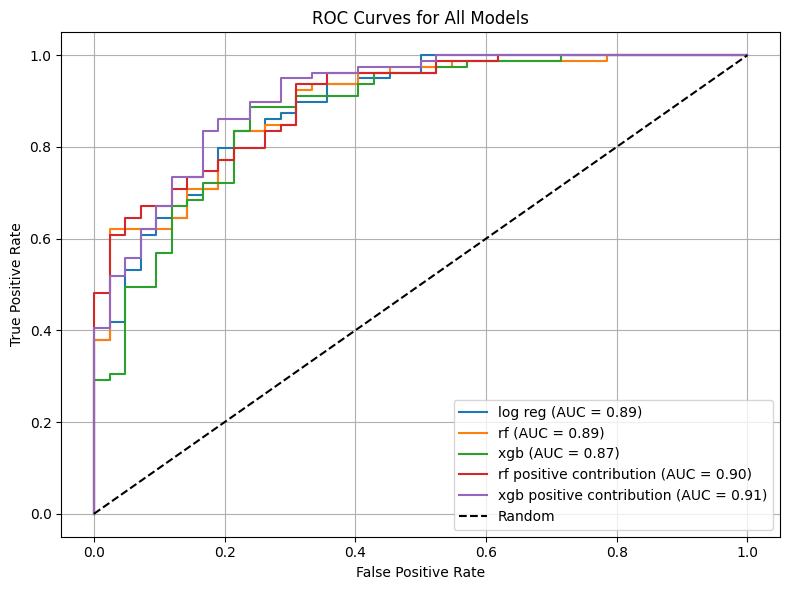

In [ ]:
plot_multiple_roc_curves_from_scores({"log reg": y_proba_baseline, "rf": y_proba_rf, "xgb": y_proba_xgb, "rf positive contribution": y_proba_rf_pos_con, "xgb positive contribution": y_proba_xgb_pos_con}, y_test, title="ROC Curves for All Models")

### model zonder schepkwaliteitindicatoren
wat kunnen ze doen, alleen info voor de schep geweten

In [ ]:
X_train.columns

Index(['ervaring_schepper', 'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg',
       'is_schepper_bank', 'is_kopper_bank', 'schepper_pos_rechts',
       'kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen',
       'score_verschil_voor', 'score_eigen', 'score_tegenstander',
       'wedstrijd_corner_nr', 'ploeg_wedstrijd_corner_nr',
       'positie_verticaal_voor', 'ploeg_scoreperc', 'goal_lag_ploeg',
       'goal_lag_wedstrijd', 'klassement', 'klassement_veschil',
       'is_degradatieplaats', 'is_promotieplaats', 'niveau_kern_laag',
       'niveau_nationaal', 'kwart_2', 'kwart_3', 'kwart_4',
       'positie_horizontaal_midden', 'positie_horizontaal_rechts', 'periode_2',
       'periode_3', 'periode_4'],
      dtype='object')

In [ ]:
# 
X_train_voor = X_train.drop(columns=['kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen'])
X_test_voor = X_test.drop(columns=['kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen'])

In [ ]:
# aangezien er geen grote verschillen zijn tsn de modellen, ga ik zowel random forest en xgboost gebruiken
best_rf_voor, y_pred_rf_voor, y_proba_rf_voor, best_param_rf_voor = train_random_forest_with_tuning(X_train_voor, X_test_voor, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


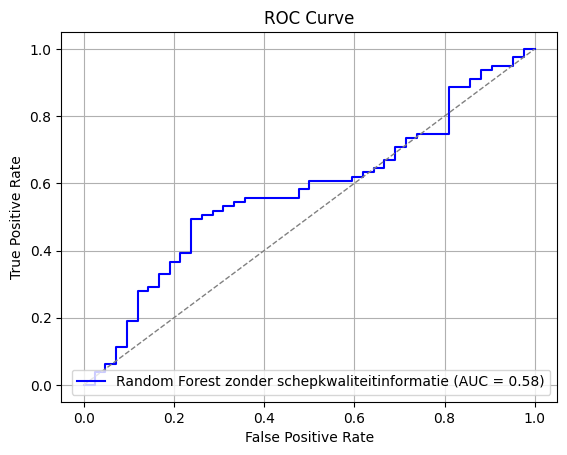

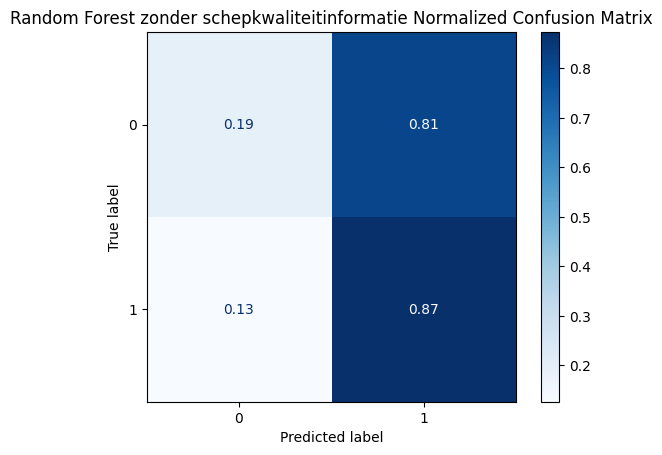

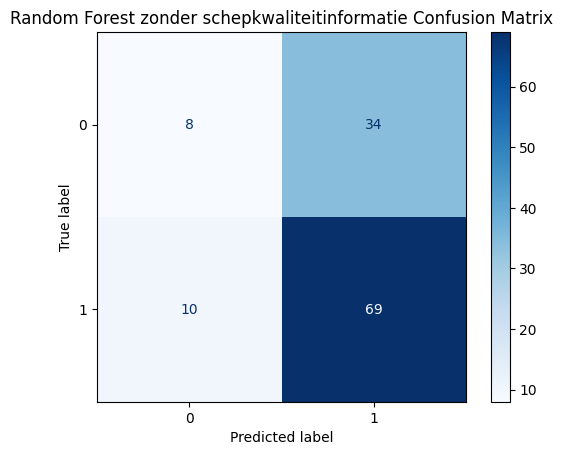


📊 Classification Report for Random Forest zonder schepkwaliteitinformatie:
Accuracy:  0.6364
Precision: 0.6699
Recall:    0.8734
F1 Score:  0.7582
ROC AUC:   0.5763


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_rf_voor, label="Random Forest zonder schepkwaliteitinformatie")
plot_confusion_matrix(y_test, y_pred_rf_voor, normalize="true", title="Random Forest zonder schepkwaliteitinformatie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_voor, title = "Random Forest zonder schepkwaliteitinformatie Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_voor, y_proba_rf_voor, model_name="Random Forest zonder schepkwaliteitinformatie")


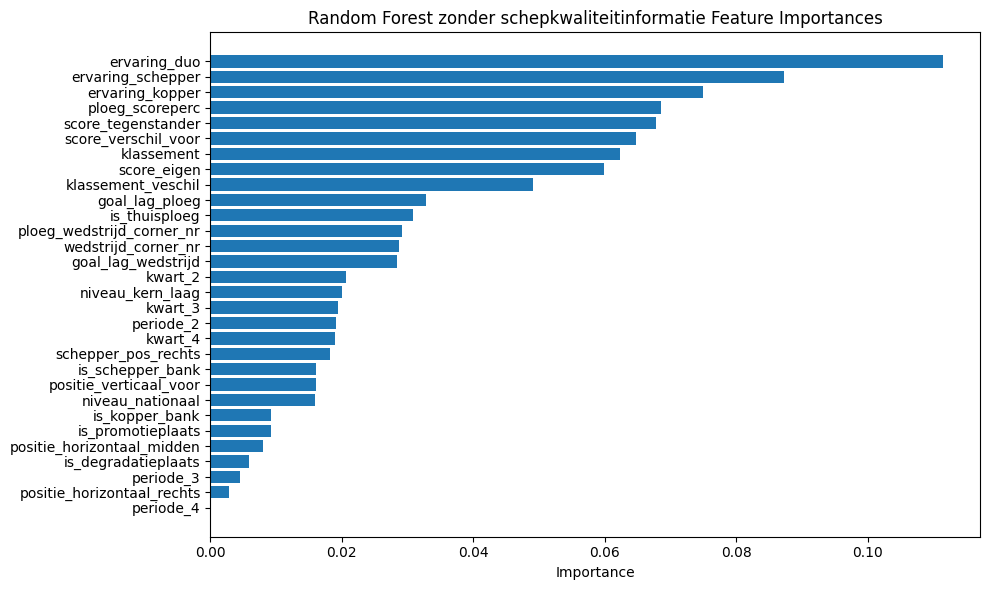

In [ ]:
importances = best_rf_voor.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train_voor.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest zonder schepkwaliteitinformatie Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

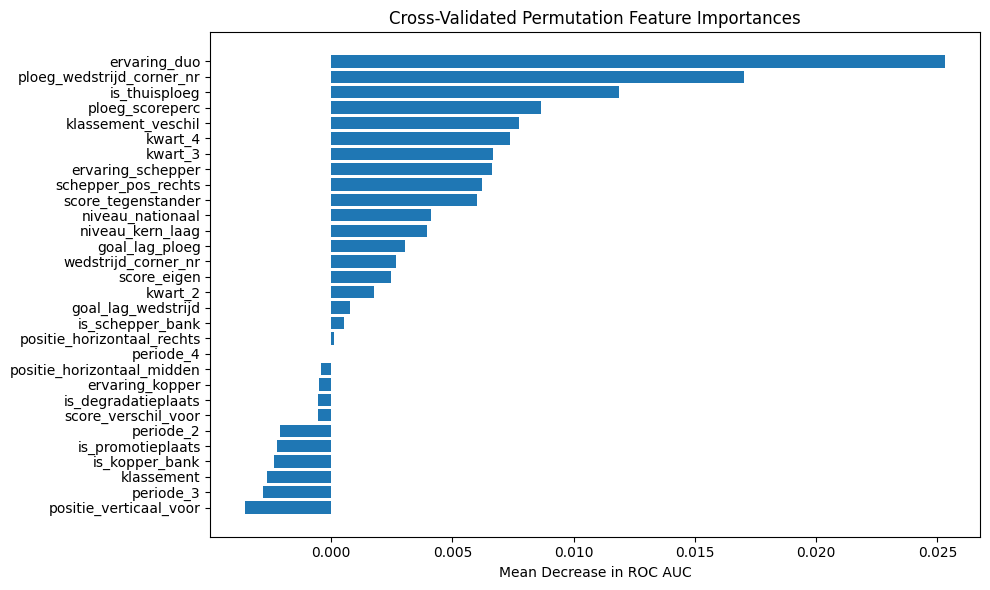

In [ ]:
### permuting
rf_voor_permuted = cross_validated_permutation_importance(
    model_class=RandomForestClassifier,
    X=X_train_voor,
    y=y_train,
    param_dict=best_param_rf_voor,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
)

In [ ]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_rf_voor = rf_voor_permuted[rf_voor_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use_rf_voor = [item for item in rf_voor_permuted["feature"].to_list() if item not in feat_to_remove_rf_voor]

In [ ]:
best_rf_voor_pos_con, y_pred_rf_voor_pos_con, y_pred_proba_voor_pos_con, best_param_rf_voor_pos_con = train_random_forest_with_tuning(X_train_voor[cols_to_use_rf_voor], X_test_voor[cols_to_use_rf_voor], y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


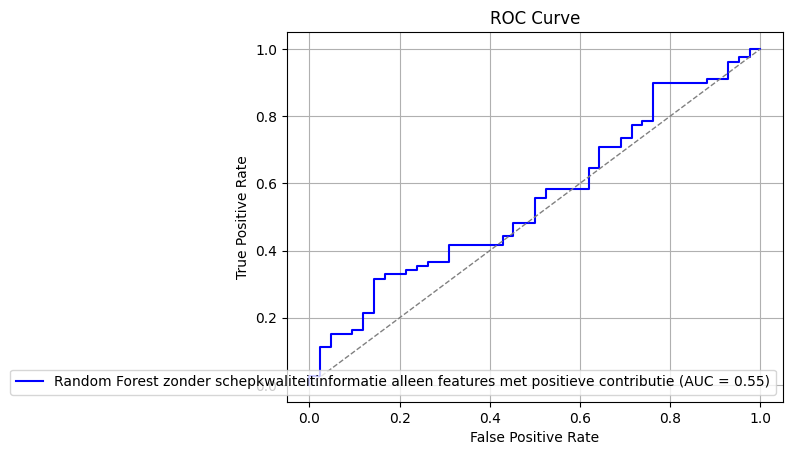

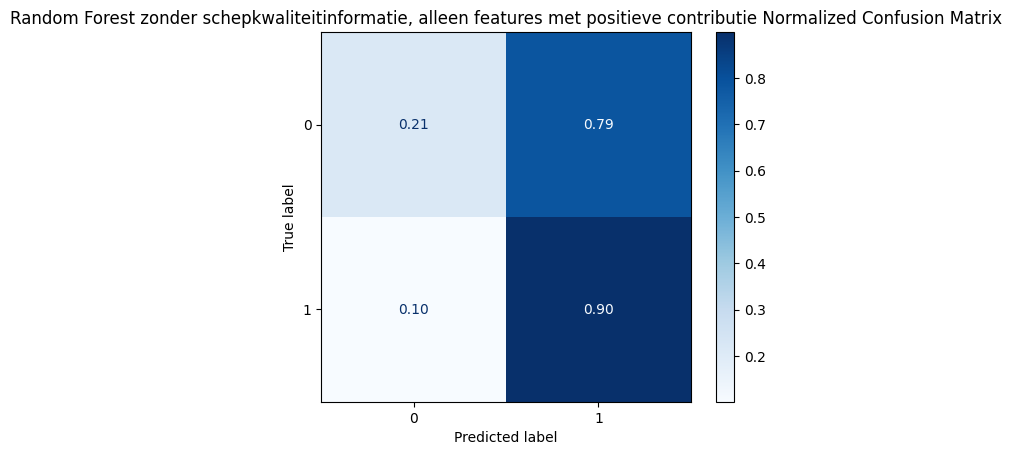

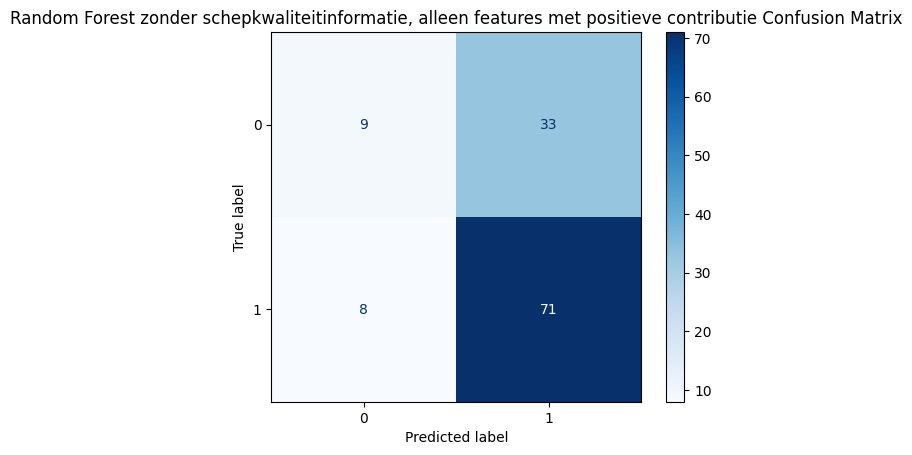


📊 Classification Report for Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie:
Accuracy:  0.6612
Precision: 0.6827
Recall:    0.8987
F1 Score:  0.7760
ROC AUC:   0.5527


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_pred_proba_voor_pos_con, label="Random Forest zonder schepkwaliteitinformatie alleen features met positieve contributie")
plot_confusion_matrix(y_test, y_pred_rf_voor_pos_con, normalize="true", title="Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf_voor_pos_con, title = "Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie Confusion Matrix")
print_classification_metrics(y_test, y_pred_rf_voor_pos_con, y_pred_proba_voor_pos_con, model_name="Random Forest zonder schepkwaliteitinformatie, alleen features met positieve contributie")


### XGBoost zonder schepkwaliteitindicatoren

In [ ]:
best_xgb_voor, y_pred_xgb_voor, y_proba_xgb_voor, best_param_xgb_voor = train_xgb_with_tuning(X_train_voor, X_test_voor, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


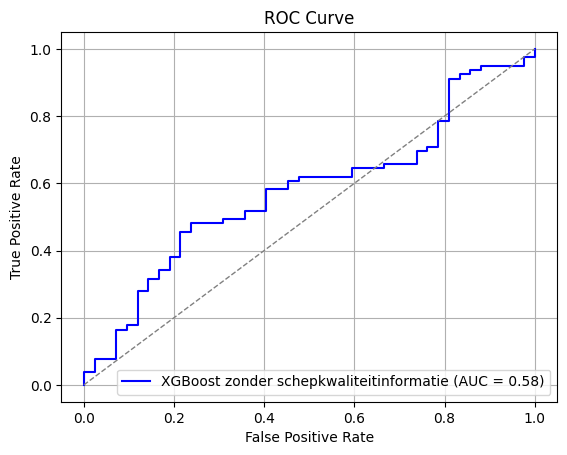

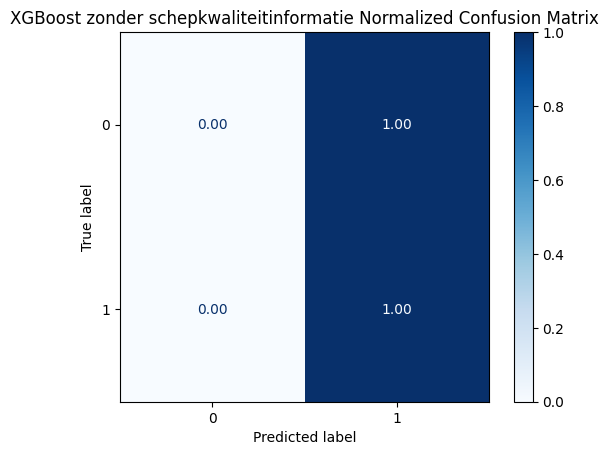

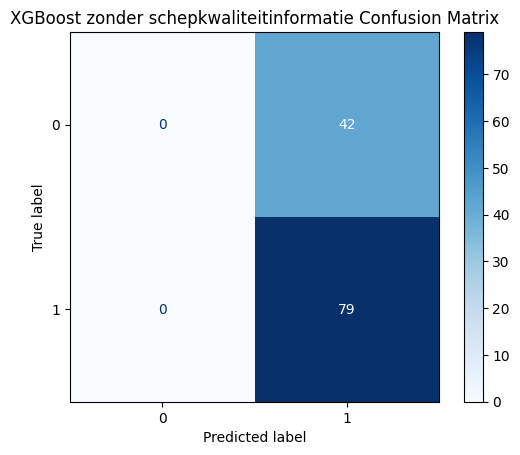


📊 Classification Report for XGBoost zonder schepkwaliteitinformatie:
Accuracy:  0.6529
Precision: 0.6529
Recall:    1.0000
F1 Score:  0.7900
ROC AUC:   0.5784


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_voor, label="XGBoost zonder schepkwaliteitinformatie")
plot_confusion_matrix(y_test, y_pred_xgb_voor, normalize="true", title="XGBoost zonder schepkwaliteitinformatie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_voor, title = "XGBoost zonder schepkwaliteitinformatie Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_voor, y_proba_xgb_voor, model_name="XGBoost zonder schepkwaliteitinformatie")


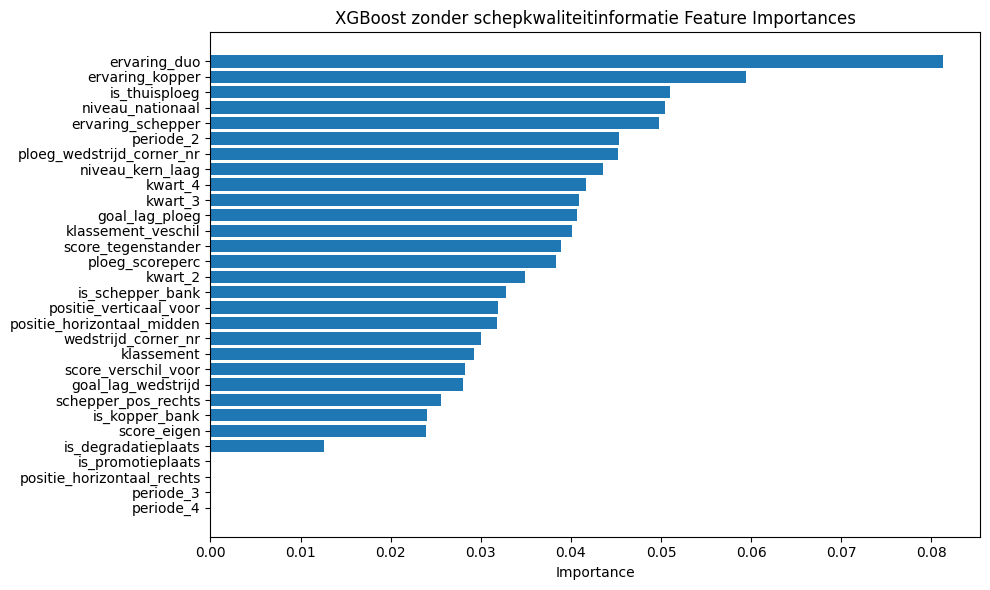

In [ ]:
importances = best_xgb_voor.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "feature": X_train_voor.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost zonder schepkwaliteitinformatie Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

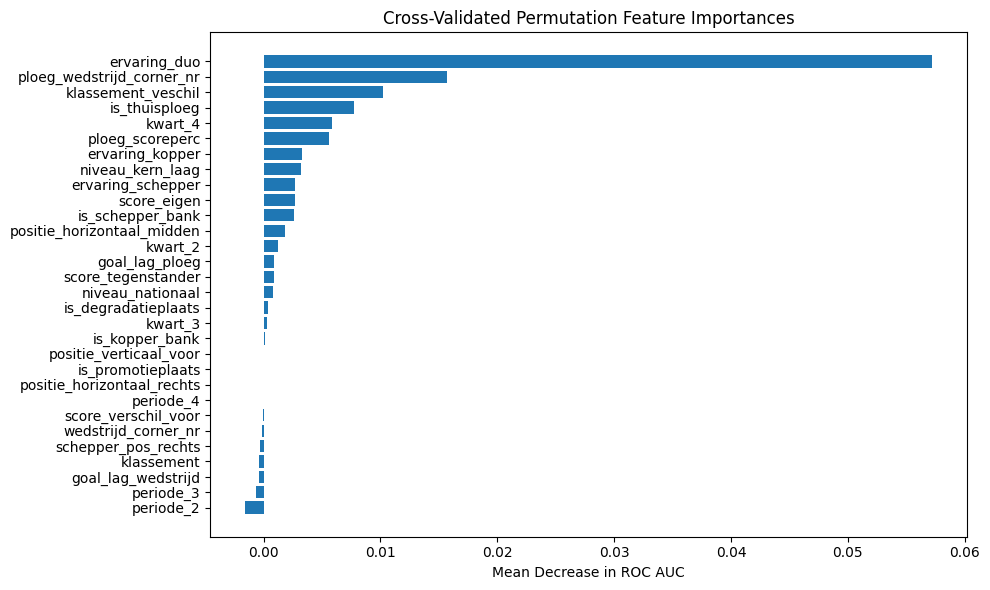

In [ ]:
### permuting
xgb_voor_permuted = cross_validated_permutation_importance(
    model_class=XGBClassifier,
    X=X_train_voor,
    y=y_train,
    param_dict=best_param_xgb_voor,
    scoring="roc_auc",
    n_splits=5,
    n_repeats=10,
)

In [ ]:
# select all columns with negative mean_decrease and remove them
feat_to_remove_xgb_voor = xgb_voor_permuted[xgb_voor_permuted["mean_importance"] < 0]["feature"].to_list()
cols_to_use_xgb_voor = [item for item in xgb_voor_permuted["feature"].to_list() if item not in feat_to_remove_xgb_voor]

In [ ]:
best_xgb_voor_pos_con, y_pred_xgb_voor_pos_con, y_proba_xgb_voor_pos_con, best_param_xgb_voor_pos_con = train_random_forest_with_tuning(X_train_voor[cols_to_use_xgb_voor], X_test_voor[cols_to_use_xgb_voor], y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


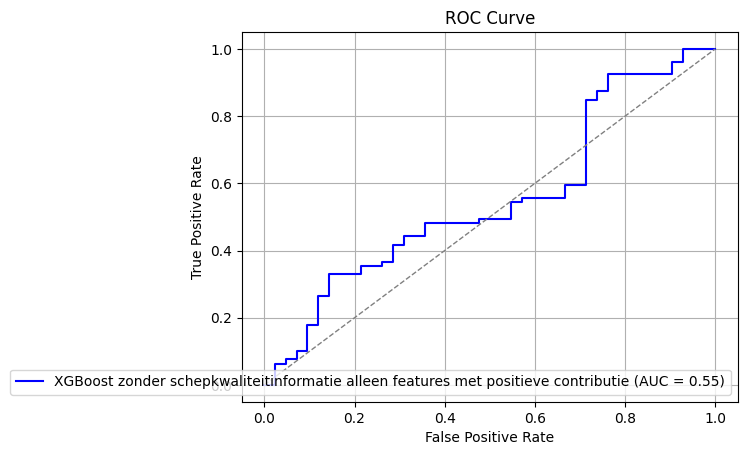

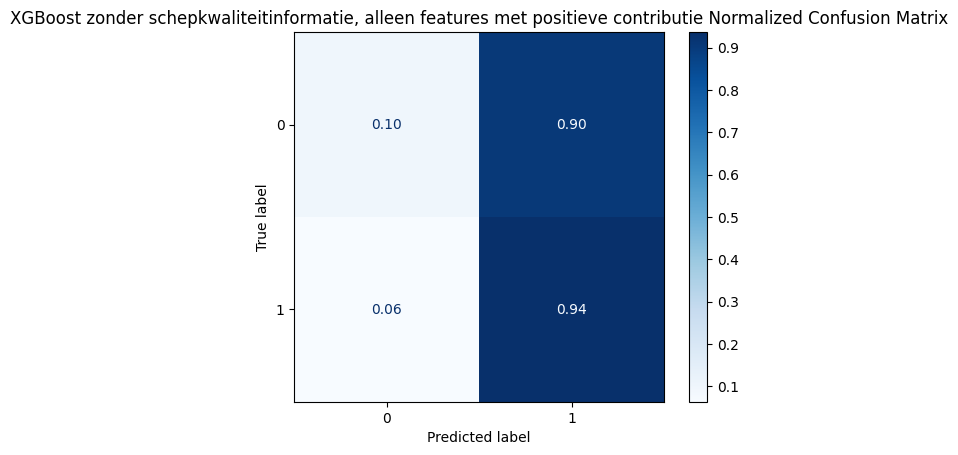

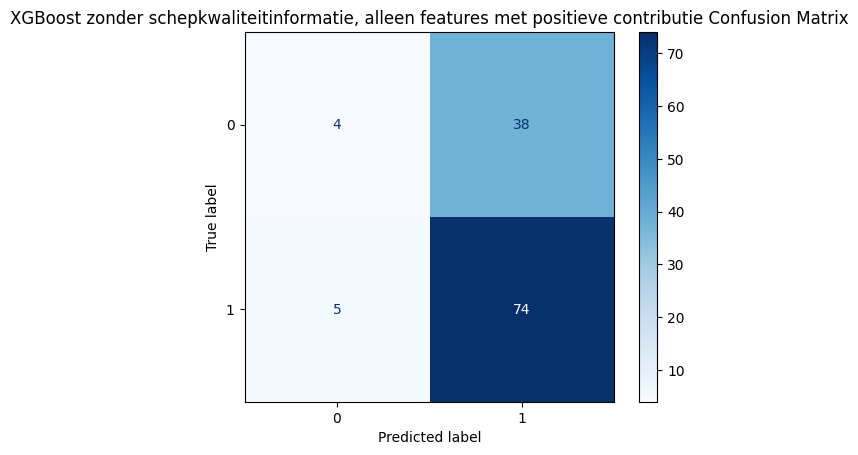


📊 Classification Report for XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie:
Accuracy:  0.6446
Precision: 0.6607
Recall:    0.9367
F1 Score:  0.7749
ROC AUC:   0.5506


In [ ]:
# Evaluation
plot_roc_curve(y_test, y_proba_xgb_voor_pos_con, label="XGBoost zonder schepkwaliteitinformatie alleen features met positieve contributie")
plot_confusion_matrix(y_test, y_pred_xgb_voor_pos_con, normalize="true", title="XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb_voor_pos_con, title = "XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie Confusion Matrix")
print_classification_metrics(y_test, y_pred_xgb_voor_pos_con, y_proba_xgb_voor_pos_con, model_name="XGBoost zonder schepkwaliteitinformatie, alleen features met positieve contributie")
